In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from scipy.signal import butter, filtfilt, lfilter
import matplotlib.pyplot as plt
import gc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.layers import TimeDistributed, Reshape, Permute
from keras.utils import to_categorical
from tensorflow import keras
import pywt
import scipy.signal as signal
from scipy.integrate import simps

import scipy

In [3]:
# ---------- FUNCTIONS ---------- #

#___SCALING___#
def apply_scaling(array):
  array_norm = np.zeros((array.shape[0],array.shape[1]))
  for i in range(array.shape[0]):
    means = np.mean(array[i])  # Calculate mean for each sensor
    stds = np.std(array[i])    # Calculate standard deviation for each sensor
    array_norm[i] = (array[i] - means) / stds   # Subtrack and divide

  del array, means, stds
  gc.collect()
  return array_norm

#___LOWPASS FILTER___#
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def apply_lowpass(array):
  original_sampling_rate = 2034  # Original sampling rate
  downsampling_factor = 4
  new_sampling_rate = original_sampling_rate / downsampling_factor  # New sampling rate after downsampling
  cutoff_frequency = new_sampling_rate / 2  # Nyquist frequency

  array_filtered = np.zeros((array.shape[0], array.shape[1]))

  for i in range(array.shape[0]):  # Iterate over sensors
      array_filtered[i, :] = butter_lowpass_filter(array[i, :], cutoff_frequency, original_sampling_rate)

  del array
  return array_filtered

#___DOWNSAMPLING___#
def apply_downsampling(array):
  n_sensors, n_timepoints = array.shape

  downsampling_factor = 4
  new_n_timepoints = n_timepoints // downsampling_factor
  array_downsamp = np.zeros((n_sensors, new_n_timepoints))

  for sensor in range(n_sensors):
    array_downsamp[sensor,:] = array[sensor, ::downsampling_factor]

  del array, new_n_timepoints, downsampling_factor, n_sensors, n_timepoints
  gc.collect()
  return array_downsamp


#___BANDS AND STATS___#
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    y = scipy.signal.filtfilt(b, a, data)
    return y


def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    y = scipy.signal.filtfilt(b, a, data)
    return y

def extract_frequency_bands(data, fs):
    # Define the frequency bands
    bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30), 'gamma': (30, 80)}

    # Initialize the output
    extracted_features = np.zeros((data.shape[0], 25))  # 248 sensors, 5 bands * 5 features

    for sensor_index in range(data.shape[0]):
        sensor_data = data[sensor_index, :]

        features = []
        for band in bands.values():
            # Apply bandpass filter
            band_data = bandpass_filter(sensor_data, band[0], band[1], fs=fs)

            # Calculate statistical features
            features.append(np.mean(band_data))
            features.append(np.std(band_data))
            features.append(scipy.stats.skew(band_data))
            features.append(scipy.stats.kurtosis(band_data))
            features.append(np.sum(np.square(band_data)))  # Energy

        extracted_features[sensor_index, :] = features

    return extracted_features


def calculate_single_channel_features(data, segment_length):
    """
    Calculate single-channel features by segmenting the data and calculating the mean.

    :param data: Input data of shape (num_sensors, num_timepoints)
    :param segment_length: Length of each segment for calculating the mean
    :return: Single-channel features of shape (num_sensors, num_segments)
    """
    num_sensors, num_timepoints = data.shape
    num_segments = num_timepoints // segment_length
    single_channel_features = np.zeros((num_sensors, num_segments))

    for sensor in range(num_sensors):
        for segment in range(num_segments):
            start = segment * segment_length
            end = start + segment_length
            single_channel_features[sensor, segment] = np.mean(data[sensor, start:end])

    return single_channel_features


In [4]:
# LOAD FILES

def get_file_paths_and_labels(data_folder, task_numbers):
  file_paths = []
  labels = []
  for task_number in task_numbers:
      for file in os.listdir(data_folder):
          if file.endswith(task_number + 'h5'):
              file_path = os.path.join(data_folder, file)
              file_paths.append(file_path)
              labels.append(assign_label(file))
  return file_paths, labels

def find_fmri_data_folder(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'meg_data' in dirs:
            return os.path.join(root, 'meg_data/Intra/train')
    raise Exception("meg_data folder not found. Please check the directory structure.")

def load_data(file_path):
  with h5py.File(file_path, 'r') as f:
      dataset_name = get_dataset_name(file_path)
      matrix = f.get(dataset_name)[:]
      return matrix

def get_dataset_name(file_name_with_dir):
  filename_without_dir = file_name_with_dir.split('/')[-1]
  temp = filename_without_dir.split('_')[:-1]
  dataset_name = "_".join(temp)
  return dataset_name

def assign_label(file_name):
  if file_name.startswith("rest"):
      return 0
  elif file_name.startswith("task_motor"):
      return 1
  elif file_name.startswith("task_story"):
      return 2
  elif file_name.startswith("task_working"):
      return 3
  else:
      return None

def count_files_with_task_numbers(data_folder, task_numbers):
    total_files = 0
    for file in os.listdir(data_folder):
        if any(file.endswith(task_number + 'h5') for task_number in task_numbers):
            total_files += 1
    return total_files

In [5]:
# Retieve the initial data from the folder

fmri_data_folder = find_fmri_data_folder('/content/drive')
print("fmri_data_folder:", fmri_data_folder)

meg_data_list = []
labels = []

for file in os.listdir(fmri_data_folder):
    if file.endswith('.h5'):
        file_path = os.path.join(fmri_data_folder, file)
        data = load_data(file_path)
        meg_data_list.append(data)
        labels.append(assign_label(file))

        # Clear memory
        del data
        gc.collect()

# Convert the list of 2D arrays into a single 3D NumPy array
meg_train_data_array = np.stack(meg_data_list, axis=0)
labels_train_array = np.array(labels)

del meg_data_list, labels

fmri_data_folder: /content/drive/MyDrive/Courses/Pattern Recognition/Lab/Group Assignment/meg_data/Intra/train


In [6]:
print("## Initial shapes of the data ##")
print("MEG:", meg_train_data_array.shape)
print("Labels:",labels_train_array.shape)

## Initial shapes of the data ##
MEG: (32, 248, 35624)
Labels: (32,)


In [17]:
# Call Preprocessing functions
def preprocess_data(data, i):
  print(f"*** FILE {i} ***")
  data = data[:, :-8]
  data = apply_scaling(data)
  print("scaling applied: shape:", data.shape, end=', ')
  # data = apply_lowpass(data)
  # print("lowpass applied: shape:", data.shape, end=', ')
  data = apply_downsampling(data)
  print("downsam applied: shape:", data.shape)
  return np.array(data)


In [13]:
# ----- CALL PROCESSING FUNCTIONS FOR ALL FILES ----- #

processed_data = np.zeros((meg_train_data_array.shape[0], meg_train_data_array.shape[1], 8904))
print(processed_data.shape)
for i in range(meg_train_data_array.shape[0]):
  processed_data[i] = preprocess_data(meg_train_data_array[i], i+1)

(32, 248, 8904)
*** FILE 1 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), *** FILE 2 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), *** FILE 3 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), *** FILE 4 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), *** FILE 5 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), *** FILE 6 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), *** FILE 7 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), *** FILE 8 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), *** FILE 9 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), *** FILE 10 ***
scaling applied: shape: (248, 35616), lowpass applied: shape: (248, 35616), *** FILE 11 ***
scaling applied: shape: (248, 35616), lowpass applied: sh

Text(0, 0.5, 'Amplitude')

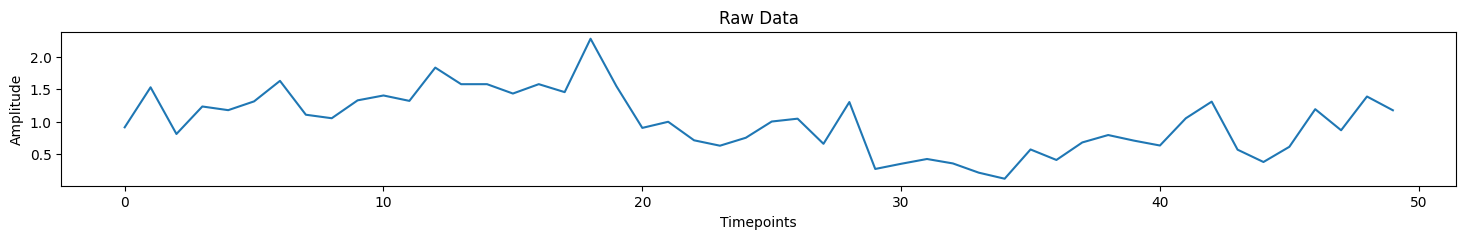

In [24]:
# Visualize the signal of the first sensor after each step
import matplotlib.pyplot as plt

# Assuming each array is a NumPy array and the first sensor's data is the first row
# Example: raw_data[0, :], scaled_data[0, :], etc.

plt.figure(figsize=(18, 2))

# Plot Raw Data
plt.plot(processed_data[0,0,:50], label='Raw Data')
plt.title('Raw Data')
plt.xlabel('Timepoints')
plt.ylabel('Amplitude')


Text(0, 0.5, 'Amplitude')

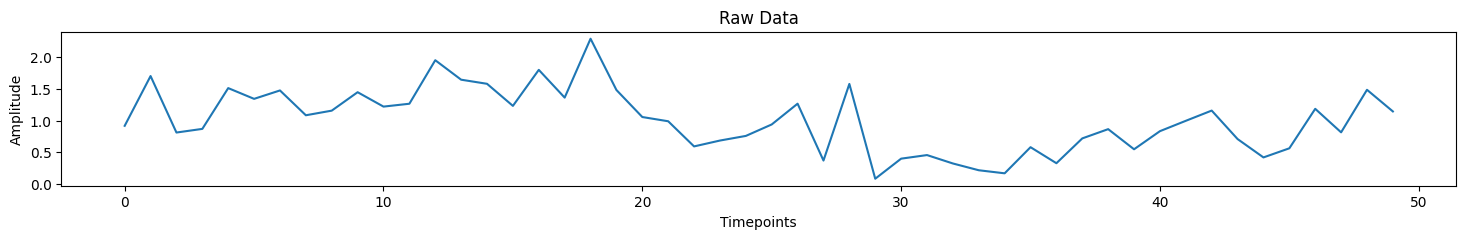

In [25]:
# Visualize the signal of the first sensor after each step
import matplotlib.pyplot as plt

# Assuming each array is a NumPy array and the first sensor's data is the first row
# Example: raw_data[0, :], scaled_data[0, :], etc.

plt.figure(figsize=(18, 2))

# Plot Raw Data
plt.plot(processed_data_no_filter[0,0,:50], label='Raw Data')
plt.title('Raw Data')
plt.xlabel('Timepoints')
plt.ylabel('Amplitude')


Text(0, 0.5, 'Amplitude')

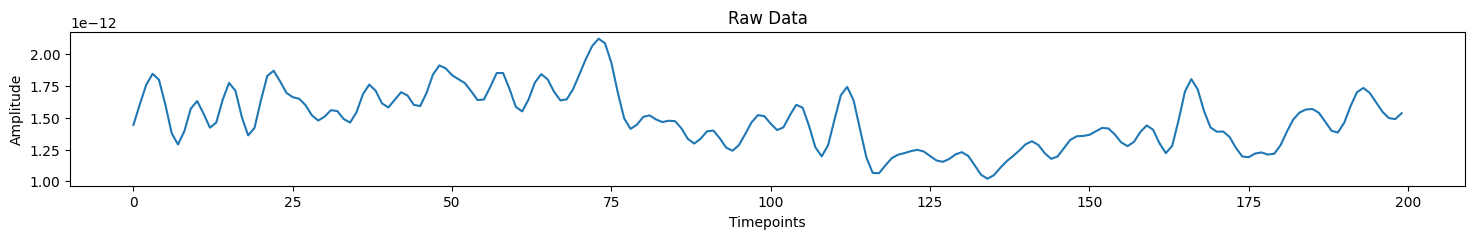

In [26]:
# Visualize the signal of the first sensor after each step
import matplotlib.pyplot as plt

# Assuming each array is a NumPy array and the first sensor's data is the first row
# Example: raw_data[0, :], scaled_data[0, :], etc.

plt.figure(figsize=(18, 2))

# Plot Raw Data
plt.plot(meg_train_data_array[0,0,:200], label='Raw Data')
plt.title('Raw Data')
plt.xlabel('Timepoints')
plt.ylabel('Amplitude')


In [18]:
# ----- CALL PROCESSING FUNCTIONS FOR ALL FILES ----- #

processed_data_no_filter = np.zeros((meg_train_data_array.shape[0], meg_train_data_array.shape[1], 8904))
print(processed_data_no_filter.shape)
for i in range(meg_train_data_array.shape[0]):
  processed_data_no_filter[i] = preprocess_data(meg_train_data_array[i], i+1)

(32, 248, 8904)
*** FILE 1 ***
scaling applied: shape: (248, 35616), downsam applied: shape: (248, 8904)
*** FILE 2 ***
scaling applied: shape: (248, 35616), downsam applied: shape: (248, 8904)
*** FILE 3 ***
scaling applied: shape: (248, 35616), downsam applied: shape: (248, 8904)
*** FILE 4 ***
scaling applied: shape: (248, 35616), downsam applied: shape: (248, 8904)
*** FILE 5 ***
scaling applied: shape: (248, 35616), downsam applied: shape: (248, 8904)
*** FILE 6 ***
scaling applied: shape: (248, 35616), downsam applied: shape: (248, 8904)
*** FILE 7 ***
scaling applied: shape: (248, 35616), downsam applied: shape: (248, 8904)
*** FILE 8 ***
scaling applied: shape: (248, 35616), downsam applied: shape: (248, 8904)
*** FILE 9 ***
scaling applied: shape: (248, 35616), downsam applied: shape: (248, 8904)
*** FILE 10 ***
scaling applied: shape: (248, 35616), downsam applied: shape: (248, 8904)
*** FILE 11 ***
scaling applied: shape: (248, 35616), downsam applied: shape: (248, 8904)
***